In [1]:
import matplotlib.pylab as plt
import numpy as np
import struct
import random
from tqdm.notebook import trange

In [2]:
# Important!: this value must represent the bytes to be cracked in the attack scenario
#####################
# usage in HW, maxcpa, ranges
bytesToProcedure = 256
#####################

# mean; to calculate the mean of a dataset (numpy optimised)
def mean(X):
    return np.sum(X, axis=0)/len(X)

def mean_np(X):
    return np.mean(X, axis=0)

''' # example code for testing
a = np.array([[5, 3, 4, 4, 5, 6],
             [27, 2, 3, 4, 12, 6],
              [1, 3, 5, 4, 5, 6],
              [1, 2, 3, 4, 5, 6],
             ]).transpose()
a_bar = mean(a)

b = np.array([[5, 4, 3, 2, 1, 3]]).transpose()
b_bar = mean(b)
'''

# standard deviation (numpy optimised)
def std_dev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2, axis=0))

def std_np(X):
    return np.std(X)

'''
o_a = std_dev(a, a_bar)
o_b = std_dev(b, b_bar)
'''

# covariance (numpy optimised)
def cov(X, X_bar, Y, Y_bar):
    return np.sum((X-X_bar)*(Y-Y_bar), axis=0)

def cov_np(X, Y):
    return np.cov(X, y=Y)

'''
ab_cov = cov(a, a_bar, b, b_bar)
'''

# hamming weight, pre-calculate => only works for the implemented range
HW = [bin(n).count("1") for n in range(0, 256)]

# hamming weight fast calculation
def hw(x):
    x -= (x >> 1) & 0x5555555555555555
    x = (x & 0x3333333333333333) + ((x >> 2) & 0x3333333333333333)
    x = (x + (x >> 4)) & 0x0f0f0f0f0f0f0f0f
    return ((x * 0x0101010101010101) & 0xffffffffffffffff) >> 56

# hamming weight numpy compatible
def hw_np(x):
    x -= (x >> 1) & 0x5555555555555555
    x = (x & 0x3333333333333333) + ((x >> 2) & 0x3333333333333333)
    x = (x + (x >> 4)) & 0x0f0f0f0f0f0f0f0f
    return (x * 0x0101010101010101) >> 56

''' # hamming weight benchmark
import time
st = time.time()
for _ in range(1000000):
    assert HW[7] == 3
print(time.time() - st)
# ~ 0.0921471118927002

st = time.time()
for _ in range(1000000):
    assert hw(7) == 3
print(time.time() - st)
# ~ 0.8255484104156494
'''


# fast Pearson Correlation Coefficient calculation
# (c) Prof. Dr. Jungk, HS-AlbSig
def corr2_coeff(A,B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:,None]
    B_mB = B - B.mean(1)[:,None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1);
    ssB = (B_mB**2).sum(1);

    # Finally get corr coeff
    return np.dot(A_mA,B_mB.T)/np.sqrt(np.dot(ssA[:,None],ssB[None])) 

In [3]:
# use measured and saved traces
trace_array = np.load('trace500-shiffthq.npy')
nc_array = np.load('nonce500-shiffthq.npy')

ntraces = len(trace_array)

In [4]:
# correct key hypothesis should give second part of Key
def round_part2(a,b,c,d):
    # perform the modular addition from round_part1, 
    # otherwise the value only contains the key part, not the constant part
    # here the output is changed to b, because it is needed 
    # and mod addition is commutative
    a = (a + b) & 0xFFFFFFFF
    # also d changes with the XOR, so calculate it again
    d = np.bitwise_xor(d, a)

    #d1 = ((d >> 16) | (d << 16)) & 0xFFFFFFFF
    c = (c + d) & 0xFFFFFFFF
    b = np.bitwise_xor(b, c)
    return b

In [5]:
# alternative implementation (should be faster)
def round_part1(constant, key0, nc):
    a = (constant + key0) & 0xFFFFFFFF
    d = (nc ^ a)
    return d

In [6]:
# constants to ints => byte by byte
c_array = ["61707865", "3320646e", "79622d32", "6b206574"]

# cs_long for second part
#cs_long = []
cs = []
for i in c_array:
    # make big endian to little endian
    ba = bytearray.fromhex(i)
    ba.reverse()
    #cs_long.append(np.uint32(struct.unpack('<L', ba)[0]))
    # some fudging (dt: pfuschen), but it works :D
    s = "0x"+''.join(format(x, '02x') for x in ba)
    for j in range(2, 10, 2):
        # fill array byte per byte
        cs.append(int(s[j:j+2], 16))

#print(f'{cs_long} {len(cs_long)}')
print(f'{cs} {len(cs)}')


[101, 120, 112, 97, 110, 100, 32, 51, 50, 45, 98, 121, 116, 101, 32, 107] 16


In [7]:
# with above numpy compatible hamming weight calculation an overflow occurs (okey!), disable warning...
np.seterr(over='ignore')

cparefsMax1 = np.zeros(bytesToProcedure) # max correlations for each byte
cparefsMin1 = np.zeros(bytesToProcedure) # min correlations for each byte

bestguessMax1 = np.zeros(16) # 128 Bit for first half of the key; put your key byte guess correlations here
bestguessMin1 = np.zeros(16) # 128 Bit for first half of the key; put your negative key byte guess correlations here


cparefsMaxX2 = np.zeros(bytesToProcedure) # max correlations for each byte
cparefsMinX2 = np.zeros(bytesToProcedure) # min correlations for each byte
cparefsMaxS2 = np.zeros(bytesToProcedure) # max correlations for each byte
cparefsMinS2 = np.zeros(bytesToProcedure) # min correlations for each byte

# 128 Bit for second half of the key; put your negative and positive key byte guess here
bestguessMaxX2 = np.zeros(16) 
bestguessMinX2 = np.zeros(16) 
bestguessMaxS2 = np.zeros(16) 
bestguessMinS2 = np.zeros(16) 

cpas1 = [0] * 16 # => get all cpas to plot
cpas2_x = [0] * 16 # => get all cpas to plot
cpas2_s = [0] * 16 # => get all cpas to plot

for bnum in trange(16, desc="Breaking 256 Bit Key"):
    
    hws = np.zeros((bytesToProcedure, ntraces))

    for i in range(ntraces):
        for kguess in range(0, bytesToProcedure):
            hws[kguess, i] =  hw_np(round_part1(cs[bnum], kguess, (nc_array[i])[bnum]))
        
    corr = corr2_coeff(hws, trace_array.transpose())

    for i in range(0, bytesToProcedure):    
        # best guess for this key-byte is the max/min argument, with his cpa
        cparefsMax1[i] = np.max(corr[i])
        cparefsMin1[i] = np.min(corr[i])
    bestguessMax1[bnum] = np.argmax(cparefsMax1)
    bestguessMin1[bnum] = np.argmin(cparefsMin1)
    
    cpas1[bnum] = corr
    
    #second part
    hws_x = np.zeros((bytesToProcedure, ntraces))
    hws_s = np.zeros((bytesToProcedure, ntraces))

    for i in range(ntraces):
        for kguess in range(0, bytesToProcedure):
            hws_x[kguess, i] =  hw_np(round_part2(cs[bnum], int(bestguessMax1[bnum]), kguess, nc_array[i, bnum]))
            hws_s[kguess, i] =  hw_np(round_part2(cs[bnum], int(bestguessMin1[bnum]), kguess, nc_array[i, bnum]))

    corr_x = corr2_coeff(hws_x, trace_array.transpose())
    corr_s = corr2_coeff(hws_s, trace_array.transpose())

    for i in range(0, bytesToProcedure):    
        # best guess for this key-byte is the max/min argument, with his cpa
        cparefsMaxX2[i] = np.max(corr_x[i])
        cparefsMinX2[i] = np.min(corr_x[i])
        cparefsMaxS2[i] = np.max(corr_s[i])
        cparefsMinS2[i] = np.min(corr_s[i])
    bestguessMaxX2[bnum] = np.argmax(cparefsMaxX2)
    bestguessMinX2[bnum] = np.argmin(cparefsMinX2)
    bestguessMaxS2[bnum] = np.argmax(cparefsMaxS2)
    bestguessMinS2[bnum] = np.argmin(cparefsMinS2)
    
    cpas2_x[bnum] = corr_x
    cpas2_s[bnum] = corr_s

    
print("Best Key Guess k0-k3 Max: ", end="")
# present the output in a more readable way
for b in bestguessMax1.astype(int): print("%02x " % b, end="")
print()
print("Best Key Guess k0-k3 Min: ", end="")
for b in bestguessMin1.astype(int): print("%02x " % b, end="")
print()
print()


print("Best Key Guess k4-k7 MaxX: ", end="")
# present the output in a more readable way
for b in bestguessMaxX2.astype(int): print("%02x " % b, end="")
print()
print("Best Key Guess k4-k7 MinX: ", end="")
for b in bestguessMinX2.astype(int): print("%02x " % b, end="")
print("\n")
print("Best Key Guess k4-k7 MaxS: ", end="")
for b in bestguessMaxS2.astype(int): print("%02x " % b, end="")
print()
print("Best Key Guess k4-k7 MinS: ", end="")
for b in bestguessMinS2.astype(int): print("%02x " % b, end="")

Breaking 256 Bit Key:   0%|          | 0/16 [00:00<?, ?it/s]

Best Key Guess k0-k3 Max: 35 eb 8f 7f 21 7e df 9d 93 d2 9d 06 0b 28 af 94 
Best Key Guess k0-k3 Min: 00 24 90 be 02 b9 e0 fc 08 d3 9e 07 0c 0d 10 95 

Best Key Guess k4-k7 MaxX: c4 fe 7b 40 21 fe ad 88 81 52 8b 82 f9 f8 7d 94 
Best Key Guess k4-k7 MinX: a6 78 0f 80 8c 7f 00 37 dc 00 fa fe 34 51 10 fc 

Best Key Guess k4-k7 MaxS: 82 12 cc c1 55 f2 e8 01 c7 00 e1 58 b1 80 55 fc 
Best Key Guess k4-k7 MinS: 00 dc 90 7f 00 80 60 9c f8 da 18 ff 04 1b 30 9f 

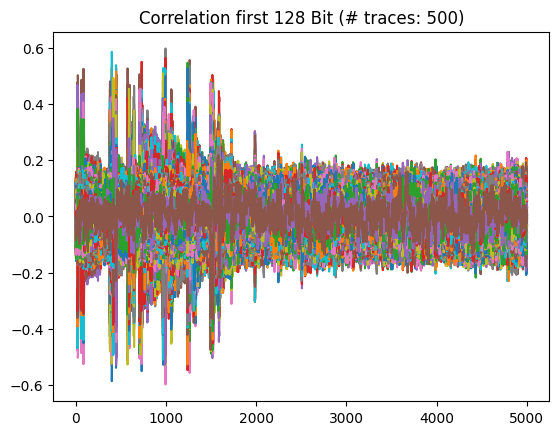

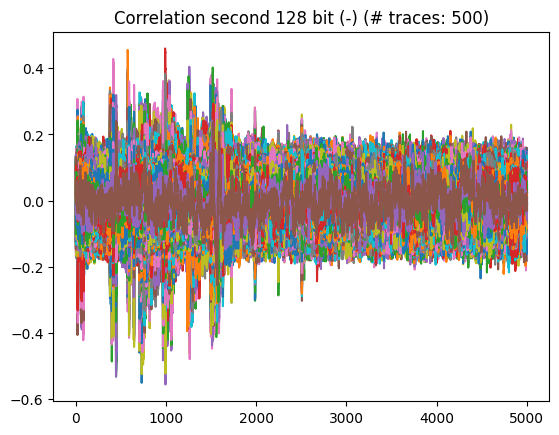

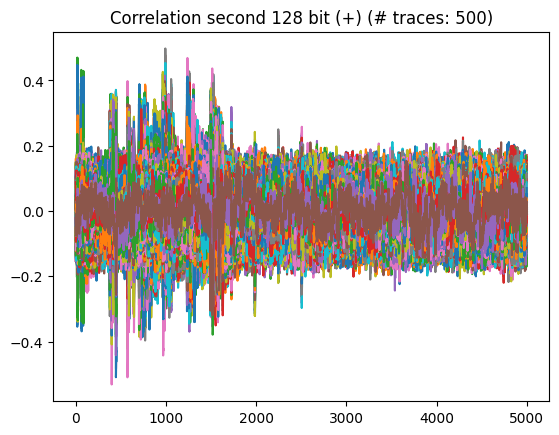

In [8]:
plt.figure()
plt.title(f"Correlation first 128 Bit (# traces: {ntraces})")
for cpa in cpas1:
    for i in range(256):
        plt.plot(cpa[i])
plt.show()

plt.figure()
plt.title(f"Correlation second 128 bit (-) (# traces: {ntraces})")
for cpa in cpas2_s:
    for i in range(256):
        plt.plot(cpa[i])
plt.show()

plt.figure()
plt.title(f"Correlation second 128 bit (+) (# traces: {ntraces})")
for cpa in cpas2_x:
    for i in range(256):
        plt.plot(cpa[i])
plt.show()

In [9]:
keylen = 32
used_key = [0x00, 0x01, 0x02, 0x03, 0x04, 0x05, 0x06, 0x07,
           0x08, 0x09, 0x0a, 0x0b, 0x0c, 0x0d, 0x0e, 0x0f,
           0x10, 0x11, 0x12, 0x13, 0x14, 0x15, 0x16, 0x17,
           0x18, 0x19, 0x1a, 0x1b, 0x1c, 0x1d, 0x1e, 0x1f]

cracked_key1= np.full(16, 256)
cracked_key2= np.full(16, 256)


for i in range(16):
    if bestguessMax1[i] == used_key[i]:
        cracked_key1[i] = bestguessMax1[i]
    elif bestguessMin1[i] == used_key[i]:
        cracked_key1[i] = bestguessMin1[i]
for i in range(16):
    if bestguessMaxX2[i] == used_key[i+16]:
        cracked_key2[i] = bestguessMaxX2[i]
    elif bestguessMinX2[i] == used_key[i+16]:
        cracked_key2[i] = bestguessMinX2[i]
for i in range(16):
    if bestguessMaxS2[i] == used_key[i+16]:
        cracked_key2[i] = bestguessMaxS2[i]
    elif bestguessMinS2[i] == used_key[i+16]:
        cracked_key2[i] = bestguessMinS2[i]
        
print("The following key elements could be recovered: ")
for b in cracked_key1.astype(int): 
    if b == 256:
        print("--", end=" ")
    else:
        print("%02x " % b, end="")
        
for b in cracked_key2.astype(int): 
    if b == 256:
        print("--", end=" ")
    else:
        print("%02x " % b, end="")
        
print()
print()
for b in range(16):
    print(f'U: {int(used_key[b]):08b}  X1: {int(bestguessMax1[b]):08b}  S1: {int(bestguessMin1[b]):08b} \
    U2: {int(used_key[b+16]):08b}  xX2: {int(bestguessMaxX2[b]):08b}  sX2: {int(bestguessMinX2[b]):08b} \
    xS2: {int(bestguessMaxS2[b]):08b}  sS2: {int(bestguessMinS2[b]):08b}')
print()


The following key elements could be recovered: 
00 -- -- -- -- -- -- -- 08 -- -- -- 0c 0d -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 

U: 00000000  X1: 00110101  S1: 00000000     U2: 00010000  xX2: 11000100  sX2: 10100110     xS2: 10000010  sS2: 00000000
U: 00000001  X1: 11101011  S1: 00100100     U2: 00010001  xX2: 11111110  sX2: 01111000     xS2: 00010010  sS2: 11011100
U: 00000010  X1: 10001111  S1: 10010000     U2: 00010010  xX2: 01111011  sX2: 00001111     xS2: 11001100  sS2: 10010000
U: 00000011  X1: 01111111  S1: 10111110     U2: 00010011  xX2: 01000000  sX2: 10000000     xS2: 11000001  sS2: 01111111
U: 00000100  X1: 00100001  S1: 00000010     U2: 00010100  xX2: 00100001  sX2: 10001100     xS2: 01010101  sS2: 00000000
U: 00000101  X1: 01111110  S1: 10111001     U2: 00010101  xX2: 11111110  sX2: 01111111     xS2: 11110010  sS2: 10000000
U: 00000110  X1: 11011111  S1: 11100000     U2: 00010110  xX2: 10101101  sX2: 00000000     xS2: 11101000  sS2: 01100000
U: 00000111  X